In [ ]:
# sentiment analysis and deep learning techniques in movie review dataset

In [135]:
from importlib import reload
import numpy as np
import sys
from imp import reload
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy


# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

#from keras.utils import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

# 1. LOADING THE DATASET DF1(LABELED TRAIN DATA) AND DF2(IMDB MOVIE REVIEW DATASET) 

In [136]:
import pandas as pd

df1 = pd.read_csv('C:/Users/LaaYen/Desktop/NIT6003 Project 1 suabsh rai/labeledTrainData.tsv.zip', delimiter="\t")
df1 = df1.drop(['id'], axis=1)
df1.head()





,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [137]:
df2 = pd.read_csv('C:/Users/LaaYen/Desktop/NIT6003 Project 1 suabsh rai/unlabeledTrainData.tsv',error_bad_lines=False,delimiter="\t")
df2 = df2.drop(['id'], axis=1)
df2.head()




b'Skipping line 43043: expected 2 fields, saw 3\n'


,review
0,"Watching Time Chasers, it obvious that it was ..."
1,I saw this film about 20 years ago and remembe...
2,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,I went to see this film with a great deal of e...
4,"Yes, I agree with everyone on this site this m..."


In [138]:
df = pd.concat([df1,df2]).reset_index(drop=True)
df.head()
df = df.iloc[:1000]


# DATA PREPARATION

In [139]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))
df.head()

,sentiment,review,Processed_Reviews
0,1.0,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,1.0,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertain film...
2,0.0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...
3,0.0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...
4,1.0,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...


In [140]:
 nlp = spacy.load("en_core_web_sm")
for row in df.Processed_Reviews : 
   
    doc = nlp(row)
   # Filter the tokens in the current row to only include adjectives
    tmp = [token.text for token in doc if token.pos_ == 'ADJ']
    
    # Join the tmp into a single string separated by spaces
    tmp_str = ' '.join(tmp)
    
   

In [141]:
df.head()

,sentiment,review,Processed_Reviews
0,1.0,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,1.0,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertain film...
2,0.0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...
3,0.0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...
4,1.0,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...


In [142]:
bigrams = Phrases(sentences= df['Processed_Reviews'])

In [143]:
trigrams = Phrases(sentences= df['Processed_Reviews'])

# LOADING EMBEDDING

In [144]:
embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[df['Processed_Reviews']]],
    vector_size = embedding_vector_size,
    min_count=3, window=5, workers=4)

In [145]:
trigrams_model.wv.vectors.shape

(70, 256)

# CREATING THE LSTM MODEL

In [146]:
# Split the data into train (70%), validation (10%), and test (20%) sets
train_val, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.1, random_state=42)

# Print the shapes of the train, validation, and test sets

print("Train set shape:", train.shape)
print("Validation set shape:", val.shape)
print("Test set shape:", test.shape)

X_train_data = train['Processed_Reviews']
Y_train_data = train.sentiment.values

Train set shape: (720, 3)
Validation set shape: (80, 3)
Test set shape: (200, 3)


In [147]:
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[X_train_data]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.key_to_index),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)


In [148]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    Y_train_data,
    test_size=0.05,
    shuffle=True,
    random_state=42)

In [149]:
def build_model(embedding_matrix: np.ndarray, input_length:input_length):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

lstm_model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 150, 256)          17920     
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                     

In [150]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])



In [151]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=5)

Epoch 1/5
7/7 [==============================] - 36s 4s/step - loss: 0.5780 - accuracy: 0.7018 - val_loss: 0.7292 - val_accuracy: 0.5833
Epoch 2/5
7/7 [==============================] - 34s 5s/step - loss: 0.5520 - accuracy: 0.7061 - val_loss: 0.7477 - val_accuracy: 0.4444
Epoch 3/5
7/7 [==============================] - 33s 5s/step - loss: 0.5343 - accuracy: 0.7164 - val_loss: 0.7126 - val_accuracy: 0.5000
Epoch 4/5
7/7 [==============================] - 35s 5s/step - loss: 0.5033 - accuracy: 0.7661 - val_loss: 0.7369 - val_accuracy: 0.4444
Epoch 5/5
7/7 [==============================] - 32s 5s/step - loss: 0.4712 - accuracy: 0.7632 - val_loss: 0.7171 - val_accuracy: 0.5833


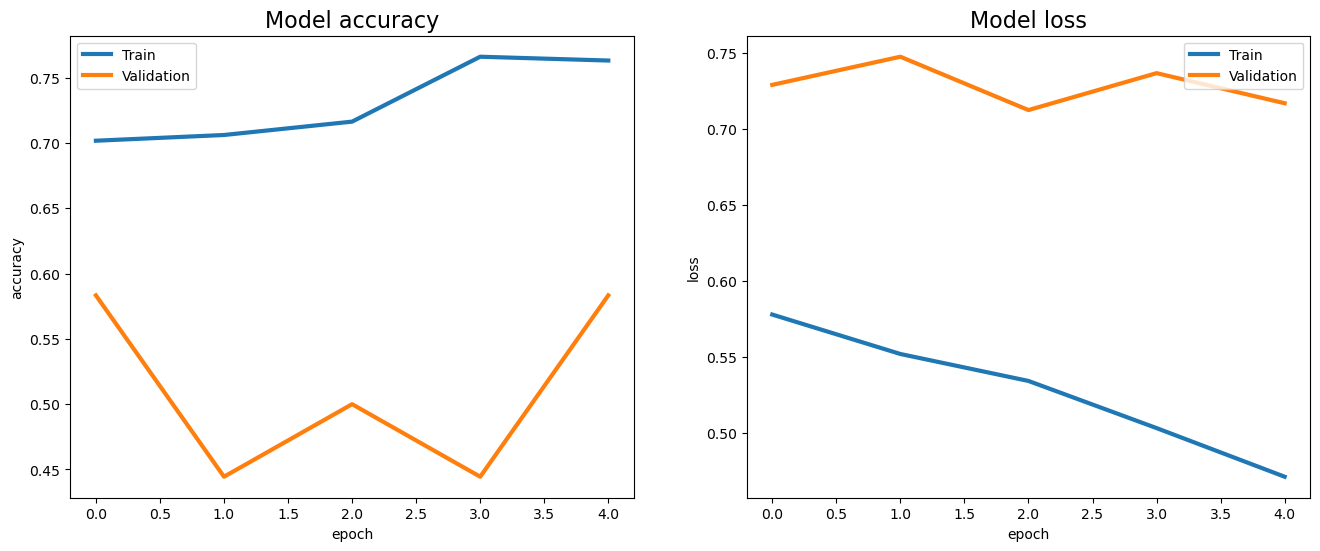

In [152]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

# GRU MODEL 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 150, 256)          17920     
                                                                 
 bidirectional_12 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                16448     
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                     

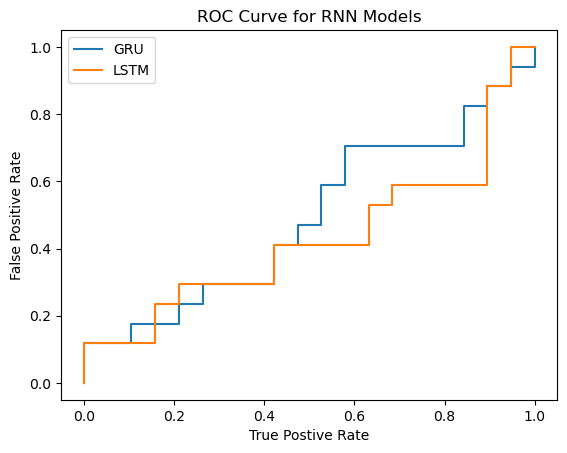

In [153]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPool1D, GRU, LSTM, Dense

gru_model = build_model(embedding_matrix=trigrams_model.wv.vectors, input_length=input_length)
gru_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
gru_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=100, epochs=5)

y_test_pred_lstm = lstm_model.predict(X_test)
y_test_pred_gru = gru_model.predict(X_test)



y_pred_list = [y_test_pred_gru, y_test_pred_lstm]
label_list = ["GRU", "LSTM"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve for RNN Models")
plt.legend()
plt.show()

# Evaluating LSTM and GRU with confusion matrix

In [154]:
print("The AUC socre for GRU model is : %.4f." %roc_auc_score(y_test, y_test_pred_gru))
print("The AUC socre for LSTM model is : %.4f." %roc_auc_score(y_test, y_test_pred_lstm))




The AUC socre for GRU model is : 0.4923.
The AUC socre for LSTM model is : 0.4303.


2/2 [==============================] - 2s 1s/step


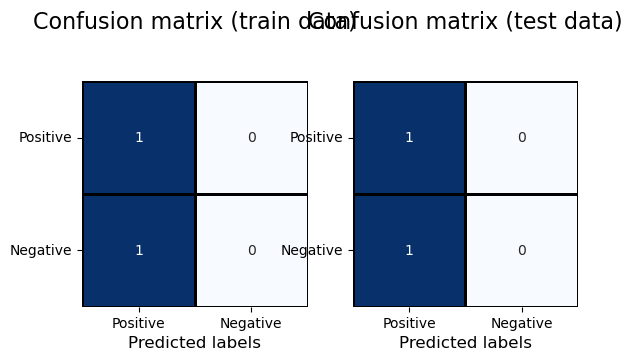

In [155]:

y_train_pred = np.argmax(gru_model.predict(X_train), axis=1)
y_test_pred = np.argmax(gru_model.predict(X_test), axis=1)

def plot_confusion_matrix(y_true, y_pred, ax, class_names, normalize=True, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    matrix = confusion_matrix(y_true,y_pred)
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=None, annot=True, square=True, ax=ax,
               cmap=cmap, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)
    
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

                 